## Setup

imports

In [1]:
import os
import sys
import glob
import shutil
import logging
from tqdm import tqdm
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import itk
import SimpleITK as sitk
import monai
from monai.data import ImageDataset, DataLoader, decollate_batch
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism
from monai.transforms import (
    EnsureChannelFirst, Compose, Activations, AsDiscrete,
    Resize, RandRotate, RandFlip, RandZoom, RandGaussianNoise,ToTensor)

monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)


MONAI version: 1.2.0+107.gc4ed1f80
Numpy version: 1.26.0
Pytorch version: 2.1.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c4ed1f80638324568cbe15851117b5494e5ec346
MONAI __file__: C:\Users\<username>\Desktop\Vrije_courses\internship\libraries\MONAI\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
scipy version: 1.11.3
Pillow version: 10.0.1
Tensorboard version: 2.15.1
gdown version: 4.7.1
TorchVision version: 0.16.2+cpu
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 2.1.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.7.1
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Set deterministic training for reproducibility

In [ ]:
import loss

In [2]:
attempt = datetime.now().strftime("%Y-%j-%M")
set_determinism(seed=0)

## Data Preprocess

Resampling and store them in another folder

In [11]:
script_dir = os.getcwd()
new_rawimg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_raw")
new_rawseg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_old_raw")
resampling_img_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "images_resampled")
resampling_seg_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "segs_old_resampled")

In [12]:
# get a list of all the patient IDs and set the mask path
patient_IDs = dict()
for file in os.listdir(new_rawimg_dir):
    if file.endswith(".nii.gz"):
        ID = file.split("_")[1]
        if ID not in patient_IDs:
            patient_IDs[ID] = 1
        else:
            patient_IDs[ID] += 1
    else:
        continue
print(f"patient counts: {len(patient_IDs)}")
print(patient_IDs)

patient counts: 102
{'004': 4, '006': 4, '007': 4, '008': 4, '010': 4, '011': 4, '012': 4, '013': 4, '014': 4, '016': 4, '017': 4, '018': 4, '019': 4, '020': 4, '021': 4, '022': 4, '023': 4, '025': 4, '026': 4, '027': 4, '030': 4, '032': 4, '033': 4, '034': 4, '035': 4, '039': 4, '043': 4, '044': 4, '046': 4, '047': 4, '048': 4, '050': 4, '051': 4, '053': 4, '055': 4, '056': 4, '058': 4, '059': 4, '060': 4, '062': 4, '063': 4, '065': 4, '066': 4, '067': 4, '069': 4, '073': 4, '074': 4, '075': 4, '076': 4, '078': 4, '079': 4, '080': 4, '083': 4, '092': 4, '097': 4, '099': 4, '102': 4, '104': 4, '105': 4, '106': 4, '108': 4, '109': 4, '110': 4, '111': 4, '112': 4, '113': 4, '114': 4, '116': 4, '117': 4, '118': 4, '120': 4, '123': 4, '124': 4, '125': 4, '176': 4, '177': 4, '178': 4, '179': 4, '180': 4, '181': 4, '182': 4, '183': 4, '185': 4, '186': 4, '187': 4, '188': 4, '189': 4, '190': 4, '277': 4, '280': 4, '282': 4, '285': 4, '288': 4, '290': 4, '291': 4, '299': 4, '301': 4, '311': 4,

Create 4D image and segmentation

In [16]:
def create_4Dimage_array(ID, is_seg=False):
    '''
    Update the created image arrary with the loaded image data

    Args:
        ID: Patient ID
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        A 4D numpy array contains 4 images or 4 duplicated segmentations.
    '''
    n_channel = patient_IDs[ID]
    img_dir = os.path.join(resampling_img_dir, f"BLT_{ID}_0000.nii.gz")
    img = sitk.ReadImage(img_dir)
    ref_shape = img.GetSize()
    x, y, z = ref_shape[2], ref_shape[1], ref_shape[0]
    combined_img = np.zeros([n_channel, x, y, z], np.float32)

    for i in range(n_channel):
        if is_seg:
            img_dir = os.path.join(resampling_seg_dir, f"BLT_{ID}_000{i}.nii.gz")
        else:
            img_dir = os.path.join(resampling_img_dir, f"BLT_{ID}_000{i}.nii.gz")
        img = sitk.ReadImage(img_dir)
        img_array = sitk.GetArrayFromImage(img)
        combined_img[i] = img_array
    return combined_img

In [35]:
changed_img_path = "C:/Users/Yin/Desktop/Vrije_courses/internship/codes/data/BLT_radiomics/image_files/images_resampled/BLT_050_0000.nii.gz"
unchanged_seg_path = "C:/Users/Yin/Desktop/Vrije_courses/internship/codes/data/BLT_radiomics/image_files/segs_old_raw/BLT_050_0000.nii.gz"

In [36]:
metadata = {
    "shape": [],
    "spacing": [],
    "direction": [],
    "origin": [],
    "pixelvalue": []}

In [37]:
changed_img = sitk.ReadImage(changed_img_path)
metadata["origin"] = changed_img.GetOrigin()
metadata["spacing"] = changed_img.GetSpacing()
metadata["shape"] = changed_img.GetSize()
metadata["direction"] = changed_img.GetDirection()
metadata["pixelvlue"] = changed_img.GetPixelIDValue()
metadata

{'shape': (313, 313, 83),
 'spacing': (1.4062750339508057, 1.4062750339508057, 2.499995708465576),
 'direction': (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0),
 'origin': (-225.7030029296875, 223.64700317382812, -79.85890197753906),
 'pixelvalue': [],
 'pixelvlue': 2}

In [38]:
unchanged_seg = sitk.ReadImage(unchanged_seg_path)
unchanged_seg.SetOrigin(metadata["origin"])
unchanged_seg.SetSpacing(metadata["spacing"])
unchanged_seg.SetDirection(metadata["direction"])
print(unchanged_seg.GetOrigin())
print(unchanged_seg.GetSpacing())
sitk.WriteImage(unchanged_seg, fileName="BLT_050_0000_new.nii.gz")

(-225.7030029296875, 223.64700317382812, -79.85890197753906)
(1.4062750339508057, 1.4062750339508057, 2.499995708465576)


In [43]:
for ID in ["039", "050"]:
    
    ####################
    ### Combinations ###
    ####################
    
    spacing_4D = (1.4062749743461609, 1.4062749743461609, 2.499995708465576, 1)
    
    ## Load image ##
    img_4D = create_4Dimage_array(ID, is_seg=False)
    image_itk_4D = itk.image_view_from_array(img_4D)
    image_itk_4D.SetSpacing(spacing_4D)
    
    ## Load segmentation ##
    mask_4D = create_4Dimage_array(ID, is_seg=True)
    mask_itk_4D = itk.image_view_from_array(mask_4D)
    mask_itk_4D.SetSpacing(spacing_4D)
    
    # print("Save results")
    # Set the path for saving 4D images
    img4D_out_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_old_NP", "images", f"BLT_{ID}.nii.gz")
    seg4D_out_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_old_NP", "segs", f"BLT_{ID}.nii.gz")
    itk.imwrite(image_itk_4D, img4D_out_dir)
    itk.imwrite(mask_itk_4D, seg4D_out_dir)

# DenseNet

In [3]:
def check_dataoverlap(train_x, val_x, test_x):
    # Check dataoverlap
    overlap = set(train_x) & set(val_x) & set(test_x)

    # Check if there is any overlap
    if overlap:
        print(f"The following elements are overlapped: {overlap}")
    else:
        print("The data have no overlapping elements.")

In [4]:
## set the data and label path
script_dir = os.getcwd()
model_dir = os.path.join(script_dir, "data", "BLT_radiomics", "models")
img4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_old_NP", "images")
seg4D_dir = os.path.join(script_dir, "data", "BLT_radiomics", "image_files", "4D_old_NP", "segs")

# image files
images = []
for file in os.listdir(img4D_dir):
    if file.endswith(".nii.gz"):
        images.append(os.path.join(img4D_dir, file))
    
# segmentation files
segs = []
for file in os.listdir(seg4D_dir):
    if file.endswith(".nii.gz"):
        segs.append(os.path.join(seg4D_dir, file))
    
# label data
label_dir = os.path.join(script_dir, "data", "BLT_radiomics", "labels_all_phases_NEW.csv")
# change label to numpy type
labels = pd.read_csv(label_dir)["Pheno"].to_numpy()
labels[labels == 4] = 2
# labels = pd.read_csv(label_dir)[['HCA', 'FNH', 'HCC']].to_numpy()
num_class = len(np.unique(labels, axis=0))

# print(images)
# print(segs)
print(f"image data count: {len(images)}.\nsegmetation data count: {len(segs)}.\nnumber of class: {num_class}")

image data count: 102.
segmetation data count: 102.
number of class: 3


In [5]:
# # Check data imbalance
# sum_phenotype = np.sum(labels, axis=0)

# fig, ax = plt.subplots()
# phenotpe = ['HCA', 'FNH', 'HCC']
# bars = ax.bar(phenotpe, sum_phenotype)
# plt.xlabel('Phenotype')
# plt.ylabel('Counts')

# bar_color = bars[0].get_facecolor()
# for bar in bars:
#   ax.text(
#       bar.get_x() + bar.get_width() / 2,
#       bar.get_height() + 0.3,
#       round(bar.get_height(), 1),
#       horizontalalignment='center',
#       color=bar_color,
#       weight='bold'
#   )

# fig.tight_layout()

In [6]:
# # Encoding
# # use factorize function to implement the encoding
# print("Encoding the labels into numeric data.")
# labels = pd.Categorical(labels, categories=['FNH', 'HCA', 'iCCA', 'HCC'])
# labels, labels_cat = pd.factorize(labels)
# print("Label data after encoding: ")
# print(labels)
# print("Corresponding label: ")
# print(labels_cat)

In [7]:
# # Load the NIfTI image
# # may chane the number to get different image
# pickedimage = np.random.randint(len(images))
# nii_image = nib.load(images[pickedimage])

# # Get the image data as a NumPy array
# image_data = nii_image.get_fdata()

# # Create a figure with multiple subplots
# num_slices = image_data.shape[2]  # Number of slices in the z-axis
# rows, cols = 2, 3  # Define the number of rows and columns for the subplots
# fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# # Plot slices in the subplots
# for i in range(rows):
#     for j in range(cols):
#         slice_index = i * cols + j
#         if slice_index < num_slices:
#             ax = axes[i, j]
#             ax.imshow(image_data[:, :, slice_index], cmap='gray')
#             ax.set_title(f'Slice {slice_index}')
#             ax.axis('off')

# # Adjust layout and show the subplots
# plt.title = f"image {pickedimage}"
# plt.tight_layout()
# plt.show()


## Prepare training

Randomly select 10% of the dataset as validation and 10% as test

In [8]:
# load a single image to get the shape
im = sitk.ReadImage(images[0])
im = im.GetSize()
print('im.shape: ', im)

# get shape mask
mask = sitk.ReadImage(segs[0])
arr_mask = sitk.GetArrayFromImage(mask)
mask = mask.GetSize()
print('mask.shape: ', mask)
print(f'mask values: {np.unique(arr_mask)}')

im.shape:  (284, 284, 83, 4)
mask.shape:  (284, 284, 83, 4)
mask values: [0. 1.]


In [9]:
# Define transforms
train_transforms = Compose([
    EnsureChannelFirst(), Resize((78,78,31)),
    # Data augmentation
    RandRotate(range_z = 0.35, prob = 0.3), RandFlip(prob = 0.5), 
    RandGaussianNoise(std=0.05, prob=0.5),
    RandZoom(prob = 0.3, min_zoom=1.0, max_zoom=1.2), ToTensor()])
val_transforms = Compose([EnsureChannelFirst(), Resize((78,78,31))])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])
y_pred_trans = Compose([Activations(softmax=True)])

# # Define image dataset, data loader
# check_ds = ImageDataset(image_files=images, seg_files=segs, labels=labels,
#                         transform=train_transforms, seg_transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=15, num_workers=2, pin_memory=torch.cuda.is_available())
# # check the data
# im, seg, label = monai.utils.misc.first(check_loader)
# print(type(im), im.shape, seg.shape, label)

# create a training data loader
train_ds = ImageDataset(image_files=train_x, seg_files=train_seg, labels=train_y,
                        transform=train_transforms, seg_transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=15, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(image_files=val_x, seg_files=val_seg, labels=val_y, 
                      transform=val_transforms, seg_transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=25, num_workers=2, pin_memory=torch.cuda.is_available())

# create a test data loader
test_ds = ImageDataset(image_files=test_x, seg_files=test_seg, labels=test_y, 
                       transform=val_transforms, seg_transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=25, num_workers=2, pin_memory=torch.cuda.is_available())

NameError: name 'train_x' is not defined

In [ ]:
class EMA:
    def __init__(self, model):
        self.model = model
        self.decay = 1 / 10
        self.shadow = {} # follow the updates of the model parameters
        self.backup = {} # store the original model parameters
        self.num_updates = 0

        # Initialize shadow weights and backup weights with the model's initial parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
                self.backup[name] = param.data.clone()

    def update(self):
        # Update the number of updates
        self.num_updates += 1

        # Calculate the decay rate based on the current number of updates
        decay = (1 + self.num_updates) / (10 + self.num_updates)

        # Update the shadow weights
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                    self.shadow[name] = new_average

    def apply_shadow(self):
        # Apply the shadow weights to the model
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        # Restore the original model parameters
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

In [ ]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=8, out_channels=num_class).to(device)
softmax = torch.nn.Softmax()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
auc_metric = ROCAUCMetric()
ema = EMA(model)

In [96]:
# start a typical PyTorch training
max_epochs = 3
val_interval = 1
best_metric = -1
best_metric_epoch = -1
writer = SummaryWriter()

# store the data
history = {
    "epoch_loss_values": [],
    "tr_AUC_values": [],
    "ts_AUC_values": [],
    "ts_ACC_values": [],
    "lrs": []
}

for epoch in range(max_epochs):
    print("-" * 15)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)
        
        train_images, train_segs, train_labels = (
            batch_data[0].to(device), 
            batch_data[1].to(device), 
            batch_data[2].to(device))
        masked_train_images = torch.cat((train_images,train_segs), dim=1) 
        
        optimizer.zero_grad()
        # print(f"current lr: {optimizer.param_groups[0]['lr']}")
        train_pred = model(masked_train_images)
        loss = loss_function(train_pred, train_labels)
        loss.backward()
        optimizer.step()
        # lrs.append(optimizer.param_groups[0]["lr"])
        # scheduler.step()
        ema.update()
        epoch_loss += loss.item()
        
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    # Calculate train AUC
        y_pred = torch.cat([y_pred, train_pred], dim=0)
        y = torch.cat([y, train_labels], dim=0)
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    auc_value = auc_metric.aggregate()
    auc_metric.reset()
    del y_pred_act, y_onehot
    history["tr_AUC_values"].append(auc_value)
    
    epoch_loss /= step
    history["epoch_loss_values"].append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        print("-"*3+"Validate"+"-"*3)
        ema.apply_shadow()
        model.eval()
        
        num_correct = 0.0
        metric_count = 0
        
        with torch.no_grad():
            for val_data in val_loader:
                y_val_pred = torch.tensor([], dtype=torch.float32, device=device)
                y_val = torch.tensor([], dtype=torch.long, device=device)
                
                val_images, val_segs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                    val_data[2].to(device))
                
                masked_val_images = torch.cat((val_images,val_segs), dim=1) # use mask
                val_pred = model(masked_val_images)
                val_argmax = val_pred.argmax(dim=1)
                val_acc = torch.eq(val_argmax, val_labels)
                metric_count += len(val_acc)
                num_correct += val_acc.sum().item()
                
            # Calculate AUC
                y_val_pred = torch.cat([y_val_pred, val_pred], dim=0)
                y_val = torch.cat([y_val, val_labels], dim=0)
            y_val_onehot = [y_trans(i) for i in decollate_batch(y_val, detach=False)]
            y_val_pred_act = [y_pred_trans(i) for i in decollate_batch(y_val_pred)]
            auc_metric(y_val_pred_act, y_val_onehot)
            val_auc_value = auc_metric.aggregate()
            auc_metric.reset()
            del y_val_pred_act, y_val_onehot
            history["ts_AUC_values"].append(val_auc_value)
            
            # Calculate Accuracy
            val_acc_value = num_correct / metric_count
            history["ts_ACC_values"].append(val_acc_value)
            
            if val_auc_value > best_metric:
                best_metric = val_auc_value
                best_metric_epoch = epoch + 1
                save_model = os.path.join(model_dir, attempt+"_baseline.pth")
                torch.save(model.state_dict(), save_model)
                print("saved new best metric model")
            print(f"Current epoch: {epoch+1}")
            print(f"AUC: {val_auc_value:.4f}; Accuracy: {val_acc_value:.4f}")
            print(f"Best AUC: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_AUC", val_auc_value, epoch + 1)
            ema.restore()
    
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

---------------
epoch 1/3
1/4, train_loss: 1.0524
2/4, train_loss: 1.2318
3/4, train_loss: 1.0162
4/4, train_loss: 1.0944
epoch 1 average loss: 1.0987
---Validate---
saved new best metric model
Current epoch: 1
AUC: 0.2218; Accuracy: 0.3333
Best AUC: 0.2218 at epoch 1
---------------
epoch 2/3
1/4, train_loss: 1.0114
2/4, train_loss: 1.0026
3/4, train_loss: 1.0060
4/4, train_loss: 1.0864
epoch 2 average loss: 1.0266
---Validate---
saved new best metric model
Current epoch: 2
AUC: 0.4264; Accuracy: 0.3810
Best AUC: 0.4264 at epoch 2
---------------
epoch 3/3
1/4, train_loss: 0.9433
2/4, train_loss: 0.8941
3/4, train_loss: 1.3519
4/4, train_loss: 0.8746
epoch 3 average loss: 1.0160
---Validate---
saved new best metric model
Current epoch: 3
AUC: 0.7882; Accuracy: 0.6190
Best AUC: 0.7882 at epoch 3
train completed, best_metric: 0.7882 at epoch: 3


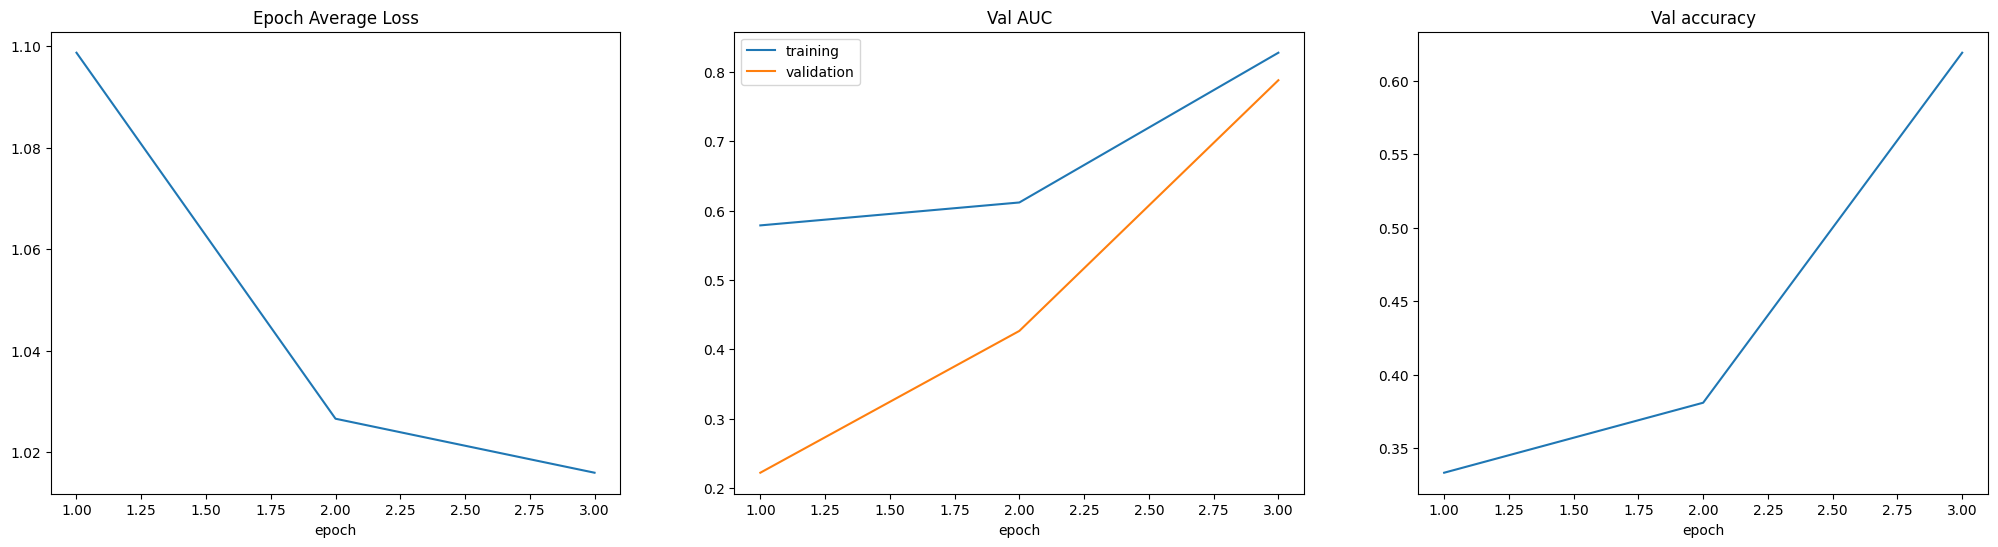

<Figure size 640x480 with 0 Axes>

In [108]:
plt.figure("train", (25, 6))
plt.subplot(1, 3, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(history["epoch_loss_values"]))]
y = history["epoch_loss_values"]
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 3, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(history["tr_AUC_values"]))]
y1 = history["tr_AUC_values"]
y2 = history["ts_AUC_values"]
plt.xlabel("epoch")
plt.plot(x, y1, label="training")
plt.plot(x, y2, label="validation")
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Val accuracy")
x = [val_interval * (i + 1) for i in range(len(history["ts_ACC_values"]))]
y = history["ts_ACC_values"]
plt.xlabel("epoch")
plt.plot(x, y)
save_dir = os.path.join(model_dir, "snap", attempt+"_base_snap.png")
plt.savefig(save_dir)
plt.show()
plt.clf()

In [112]:
random_state = 42
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
train_val_idx, test_idx = next(sss1.split(list(range(len(images))), labels))

# Further split train+val into train and val sets
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=random_state)  # 0.25 x 0.8 = 0.2
train_idx, val_idx = next(sss2.split(train_val_idx, [labels[i] for i in train_val_idx]))

# seed = random_state.get_state()[1][0]
print(f"Random state seed used: {random_state}")

Random state seed used: 42


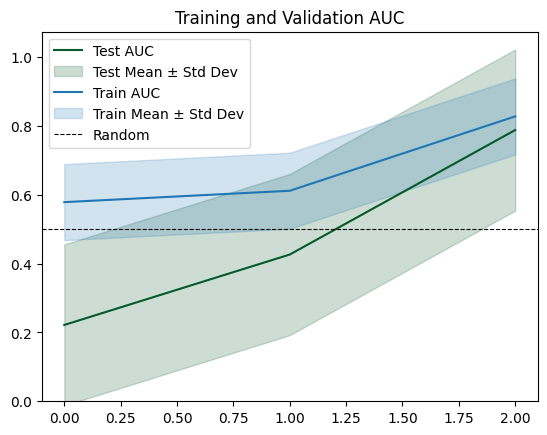

In [101]:
# Calculate mean and standard deviation for both training and test AUC
mean_ts = np.mean(history["ts_AUC_values"])
std_ts = np.std(history["ts_AUC_values"])
mean_tr = np.mean(history["tr_AUC_values"])
std_tr = np.std(history["tr_AUC_values"])

# Create an array of x values
x = range(len(history["ts_AUC_values"]))

# Plot test AUC values
plt.plot(x, history["ts_AUC_values"], label='Test AUC', color='#06592A')
plt.fill_between(x, history["ts_AUC_values"] - std_ts, history["ts_AUC_values"] + std_ts, color='#06592A', alpha=0.2, label='Test Mean ± Std Dev')

# Plot training AUC values
plt.plot(x, history["tr_AUC_values"], label='Train AUC', color='#1F77B4')
plt.fill_between(x, history["tr_AUC_values"] - std_tr, history["tr_AUC_values"] + std_tr, color='#1F77B4', alpha=0.2, label='Train Mean ± Std Dev')

# Plot a horizontal line at y=0.5 to represent random chance
plt.axhline(y=0.5, color='black', linestyle='--', lw=0.8, label='Random')

# Set the x and y axis limits
plt.xlim()
plt.ylim(bottom=0)

# Add title and legend
plt.title('Training and Validation AUC')
plt.legend()

save_dir = os.path.join(model_dir, "snap", attempt + "_base_AUC_snap.png")
plt.savefig(save_dir)

# Show the plot
plt.show()

In [103]:
model.load_state_dict(torch.load(os.path.join(model_dir, attempt+"_baseline.pth"), map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
ema.apply_shadow()
with torch.no_grad():
    model.eval()
    y_ts_true_values = []
    y_ts_pred_values = []
    
    for test_data in test_loader:
        y_ts_pred = torch.tensor([], dtype=torch.float32, device=device)
        y_ts = torch.tensor([], dtype=torch.long, device=device)
        test_images, test_segs, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
            test_data[2].to(device))
        
        masked_test_images = torch.cat((test_images,test_segs), dim=1)
        ts_pred = model(masked_test_images)
        ts_pred_argmax = ts_pred.argmax(dim=1)
        
        for i in range(len(ts_pred_argmax)):
            y_ts_true_values.append(test_labels[i].item())
            y_ts_pred_values.append(ts_pred_argmax[i].item())
            
        y_ts_pred = torch.cat([y_ts_pred, ts_pred], dim=0)
        y_ts = torch.cat([y_ts, test_labels], dim=0)
        
    y_ts_onehot = [y_trans(i) for i in decollate_batch(y_ts, detach=False)]
    y_ts_pred_act = [y_pred_trans(i) for i in decollate_batch(y_ts_pred)]
    auc_metric(y_ts_pred_act, y_ts_onehot)
    ts_auc_value = auc_metric.aggregate()
    print(f"Test AUC: {ts_auc_value}")

Test AUC: 0.671284667713239


In [104]:
print(classification_report(y_ts_true_values, y_ts_pred_values, target_names=["HCA","FNH","HCC"], digits=3))

              precision    recall  f1-score   support

         HCA      0.364     0.571     0.444         7
         FNH      0.000     0.000     0.000         6
         HCC      0.556     0.625     0.588         8

    accuracy                          0.429        21
   macro avg      0.306     0.399     0.344        21
weighted avg      0.333     0.429     0.372        21



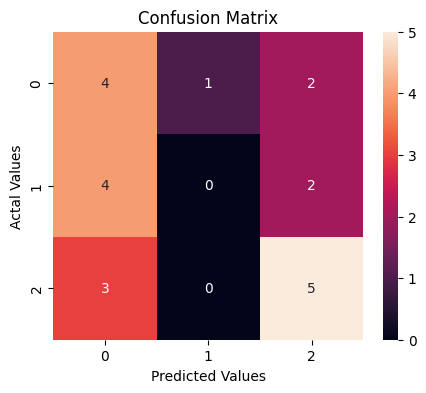

In [105]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_ts_true_values, y_ts_pred_values)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
save_dir = os.path.join(model_dir, "snap", attempt+"_base_confusion.png")
plt.savefig(save_dir)
plt.show()